In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, concatenate, Dropout, MaxPooling2D, Flatten, GRU, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use

strategy = tf.distribute.MirroredStrategy()

2022-06-21 03:29:42.738488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 03:29:44.363479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10406 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:19:00.0, compute capability: 6.1
2022-06-21 03:29:44.364230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10189 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1a:00.0, compute capability: 6.1
2022-06-21 03:29:44.364676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [2]:
location = '../datasets/train'
path_list = []
label_list = []
num_list = []
g_list = []
for (path, dir, files) in os.walk(location):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.npy':
            label = path.split('/')[-1]
            if label == '1':
                continue
            if label == '2':
                label =1
            num =  os.path.splitext(filename)[0].split('_')[-1]
            g = os.path.splitext(filename)[0].split('_')[-2][-1]
            if g == '2':
                continue
#                 g_list.append(2)
#             else:
#                 g_list.append(1)
            path_list.append(os.path.join(path,filename))
            label_list.append(label)  
            num_list.append(int(num))

df = pd.DataFrame(columns=['path', 'label','num'])
df['path'] = path_list
df['label'] = label_list
df['num'] = num_list
# df['g'] = g_list
df = df.sort_values(by=['label','num'])
                                     
df.to_csv('train.csv')    
df.head()

,path,label,num
13622,../datasets/train/2/features_train_normal_0.npy,1,0
15395,../datasets/train/2/features_train_normal_1.npy,1,1
17206,../datasets/train/2/features_train_normal_2.npy,1,2
16157,../datasets/train/2/features_train_normal_3.npy,1,3
14031,../datasets/train/2/features_train_normal_4.npy,1,4


In [3]:
location = '../datasets/val'
path_list = []
label_list = []
num_list = []
g_list = []
for (path, dir, files) in os.walk(location):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.npy':
            label = path.split('/')[-1]
            if label == '1':
                continue
            if label == '2':
                label =1
            num =  os.path.splitext(filename)[0].split('_')[-1]
            g = os.path.splitext(filename)[0].split('_')[-2][-1]
            if g == '2':
                continue
#                 g_list.append(2)
#             else:
#                 g_list.append(1)
            path_list.append(os.path.join(path,filename))
            label_list.append(label)  
            num_list.append(int(num))

df = pd.DataFrame(columns=['path', 'label','num'])
df['path'] = path_list
df['label'] = label_list
df['num'] = num_list
# df['g'] = g_list
df = df.sort_values(by=['label','num'])

                                     
df.to_csv('val.csv')    
df.head()

,path,label,num
2338,../datasets/val/2/features_val_normal_0.npy,1,0
2440,../datasets/val/2/features_val_normal_1.npy,1,1
3001,../datasets/val/2/features_val_normal_2.npy,1,2
1828,../datasets/val/2/features_val_normal_3.npy,1,3
2995,../datasets/val/2/features_val_normal_4.npy,1,4


In [4]:
train = pd.read_csv('./train.csv')
val =  pd.read_csv('./val.csv')

In [5]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [{"path": self.list_IDs["path"][k],"label": self.list_IDs["label"][k]}for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.n_channels, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(ID["path"])
            # Store class
            y[i] = ID["label"]
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
params = {'dim': [28224],
          'batch_size': 256,
          'n_classes': 2,
          'n_channels': 30,
          'shuffle': False}

train_ds = DataGenerator(train, **params)


val_ds = DataGenerator(val, **params)

In [7]:
with strategy.scope():
    
    input = keras.Input(shape=(30, 28224))  # 이미지 레이어
    
    x = GRU(512, activation='tanh')(input)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(2, activation='sigmoid')(x)
    model = keras.Model(input, output)

    model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
            metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [8]:
# with strategy.scope():
#     input = keras.Input(shape=(45, 28224))  # 이미지 레이어

#     x = LSTM(512, activation='tanh')(input)
#     x = Dense(1024, activation='relu')(x)
#     x = Dense(256, activation='sigmoid')(x)
#     output = Dense(2, activation='softmax')(x)
#     model = keras.Model(input, output)

#     model.compile(loss='mean_squared_error',
#             optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#             metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 28224)]       0         
                                                                 
 gru (GRU)                   (None, 512)               44141568  
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328

In [10]:


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
               ModelCheckpoint(filepath='./model.h5',monitor='val_accuracy',verbose=1, save_best_only=True),
               ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3,verbose=1,mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=50, verbose=1, mode='auto')
    ]
)

2022-06-21 03:29:46.691146: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 867041280 exceeds 10% of free system memory.
2022-06-21 03:29:47.306596: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_911"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
 

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

2022-06-21 03:29:56.224914: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 867041280 exceeds 10% of free system memory.
2022-06-21 03:29:57.729813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-21 03:29:58.845700: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 867041280 exceeds 10% of free system memory.
2022-06-21 03:29:58.876669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-21 03:29:59.452754: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-21 03:30:01.035176: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-21 03:30:01.081614: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 867041280 exceeds 10% of free system memory.


 2/67 [..............................] - ETA: 43s - loss: 0.9225 - accuracy: 0.0938  

2022-06-21 03:30:03.229364: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 867041280 exceeds 10% of free system memory.


67/67 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5796

2022-06-21 03:32:27.173104: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_13486"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:41"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  ke


Epoch 1: val_accuracy improved from -inf to 0.57682, saving model to ./model.h5
67/67 [==============================] - 192s 3s/step - loss: 0.6865 - accuracy: 0.5796 - val_loss: 0.7092 - val_accuracy: 0.5768 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.6565
Epoch 2: val_accuracy improved from 0.57682 to 0.58919, saving model to ./model.h5
67/67 [==============================] - 174s 3s/step - loss: 0.6520 - accuracy: 0.6565 - val_loss: 0.6927 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.6743
Epoch 3: val_accuracy improved from 0.58919 to 0.63639, saving model to ./model.h5
67/67 [==============================] - 184s 3s/step - loss: 0.6248 - accuracy: 0.6743 - val_loss: 0.6330 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6820
Epoch 4: val_accuracy did not improve from

In [11]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

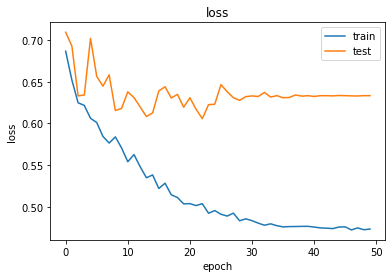

In [12]:
plt.title('loss')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("epoch")
plt.ylabel('loss')
plt.legend();

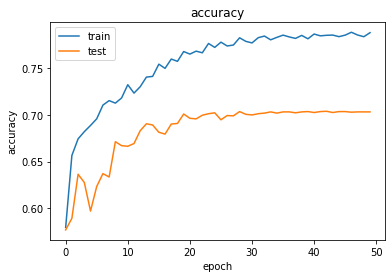

In [13]:
plt.title('accuracy')

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("epoch")
plt.ylabel('accuracy')
plt.legend();